DATA PREPROC


In [ ]:
import os
from PIL import Image
import shutil
import torch
from torchvision import transforms as t
from torch.utils.data import DataLoader as dl
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

def datapreprocess():
  transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

  dataset = ImageFolder(root='/content/ISL_SIGNLANG_CNN/DATA/ISL_TRAINING-1', transform=transform)

  train_size = int(0.8 * len(dataset))
  val_size = int(0.1 * len(dataset))
  test_size = len(dataset) - train_size - val_size

  train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=32)
  test_loader = DataLoader(test_dataset, batch_size=32)

  return train_loader, val_loader, test_loader, dataset # Return dataset as well

MODEL.PY


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes=35):
        super(SignLanguageCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(0.25)

        # Corrected input size for the linear layer
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

TRAIN.PY


In [ ]:
# train.py
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
import torch.nn as nn
import torch.optim as optim

def train(model, train_loader, val_loader, epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    acc_metric = MulticlassAccuracy(num_classes=35).to(device)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # ---- Forward ----
            outputs = model(images)
            loss = criterion(outputs, labels)

            # ---- Backward ----
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # ---- Metrics ----
            running_loss += loss.item()
            total_acc += acc_metric(outputs, labels)

        avg_loss = running_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)

        print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

        # ---- Validation ----
        model.eval()
        with torch.no_grad():
            val_acc = 0.0
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_acc += acc_metric(val_outputs, val_labels)
            print(f"Validation Accuracy: {val_acc / len(val_loader):.4f}")

In [ ]:
# Main execution block
train_loader, val_loader, test_loader, dataset = datapreprocess()
model = SignLanguageCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

epochs = 10 # You can adjust the number of epochs
train(model, train_loader, val_loader, epochs, device)

Using device: cuda
[Epoch 1] Loss: 0.1772, Accuracy: 0.9670
Validation Accuracy: 0.9988
[Epoch 2] Loss: 0.0370, Accuracy: 0.9872
Validation Accuracy: 1.0000
[Epoch 3] Loss: 0.0275, Accuracy: 0.9931
Validation Accuracy: 0.9982
[Epoch 4] Loss: 0.0105, Accuracy: 0.9970
Validation Accuracy: 0.9999
[Epoch 5] Loss: 0.0144, Accuracy: 0.9963
Validation Accuracy: 1.0000
[Epoch 6] Loss: 0.0070, Accuracy: 0.9980
Validation Accuracy: 1.0000
[Epoch 7] Loss: 0.0061, Accuracy: 0.9982
Validation Accuracy: 1.0000
[Epoch 8] Loss: 0.0091, Accuracy: 0.9980
Validation Accuracy: 1.0000
[Epoch 9] Loss: 0.0024, Accuracy: 0.9992
Validation Accuracy: 1.0000
[Epoch 10] Loss: 0.0082, Accuracy: 0.9983
Validation Accuracy: 0.9998


In [ ]:
# Save model state_dict
torch.save(model.state_dict(), 'isl_sign_model.pt')
# 1. Recreate the same model architecture
model = SignLanguageCNN()  # replace with your actual class name

# 2. Load weights into the model
model.load_state_dict(torch.load('isl_sign_model.pt'))

# 3. Move model to device
model.to(device)

# 4. Set to evaluation mode
model.eval()

SignLanguageCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=32768, out_featur

In [ ]:
from google.colab import files
files.download('isl_sign_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to make predictions
def predict(model, dataloader, device, class_names, num_images=10):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5  # Unnormalize if using Normalize([0.5], [0.5])
                plt.imshow(img)
                plt.title(f"Predicted: {class_names[preds[i]]} | True: {class_names[labels[i]]}")
                plt.axis('off')
                plt.show()
                images_shown += 1

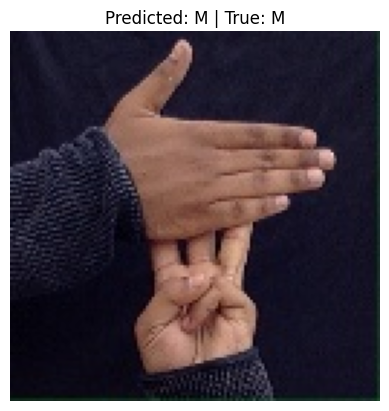

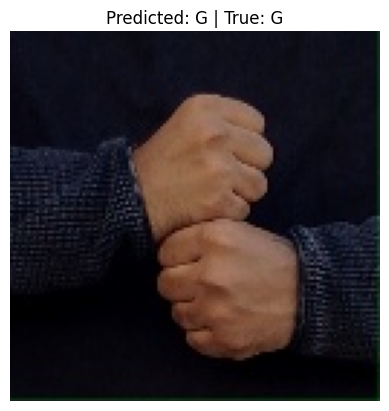

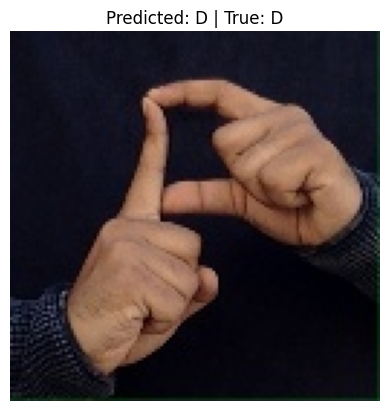

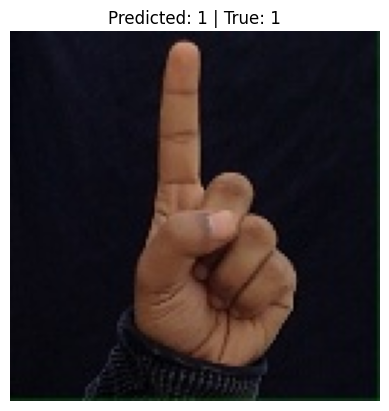

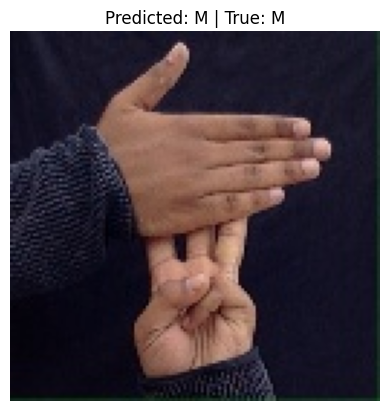

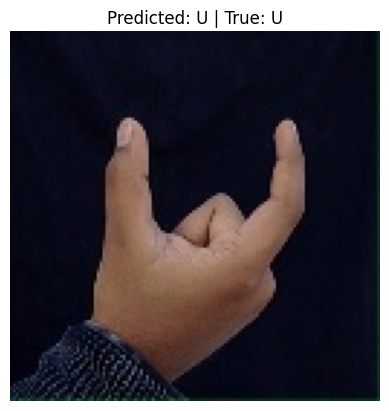

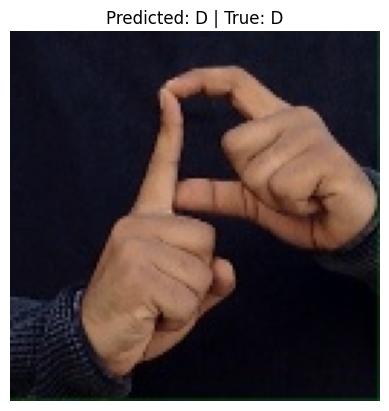

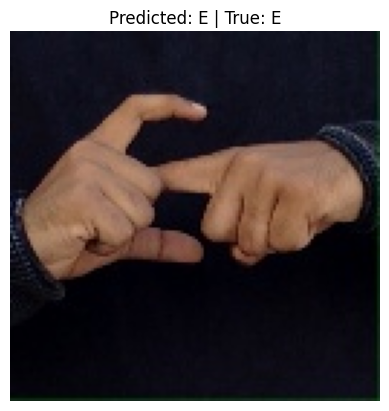

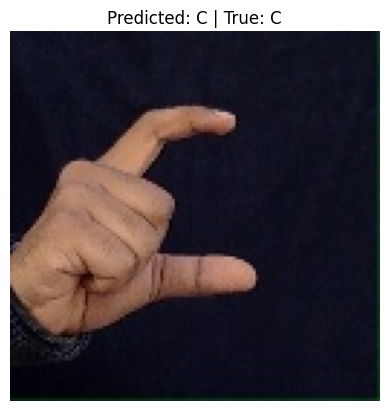

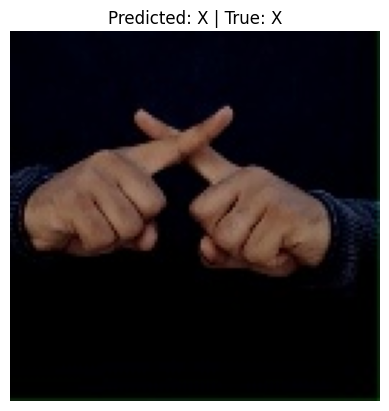

In [ ]:
# Reuse dataset and class names from preprocessing
class_names = dataset.classes

# Predict and show 10 test images
predict(model, test_loader, device, class_names, num_images=10)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       116
           2       1.00      1.00      1.00       118
           3       1.00      1.00      1.00       117
           4       1.00      1.00      1.00       140
           5       1.00      1.00      1.00       101
           6       1.00      1.00      1.00       128
           7       1.00      1.00      1.00       149
           8       1.00      1.00      1.00       113
           9       1.00      1.00      1.00       137
           A       1.00      1.00      1.00       117
           B       1.00      1.00      1.00       136
           C       1.00      1.00      1.00       151
           D       1.00      1.00      1.00       110
           E       1.00      1.00      1.00       113
           F       1.00      1.00      1.00       113
           G       1.00      1.00      1.00       128
           H       1.00      1.00      1.00        96
           I       1.00    

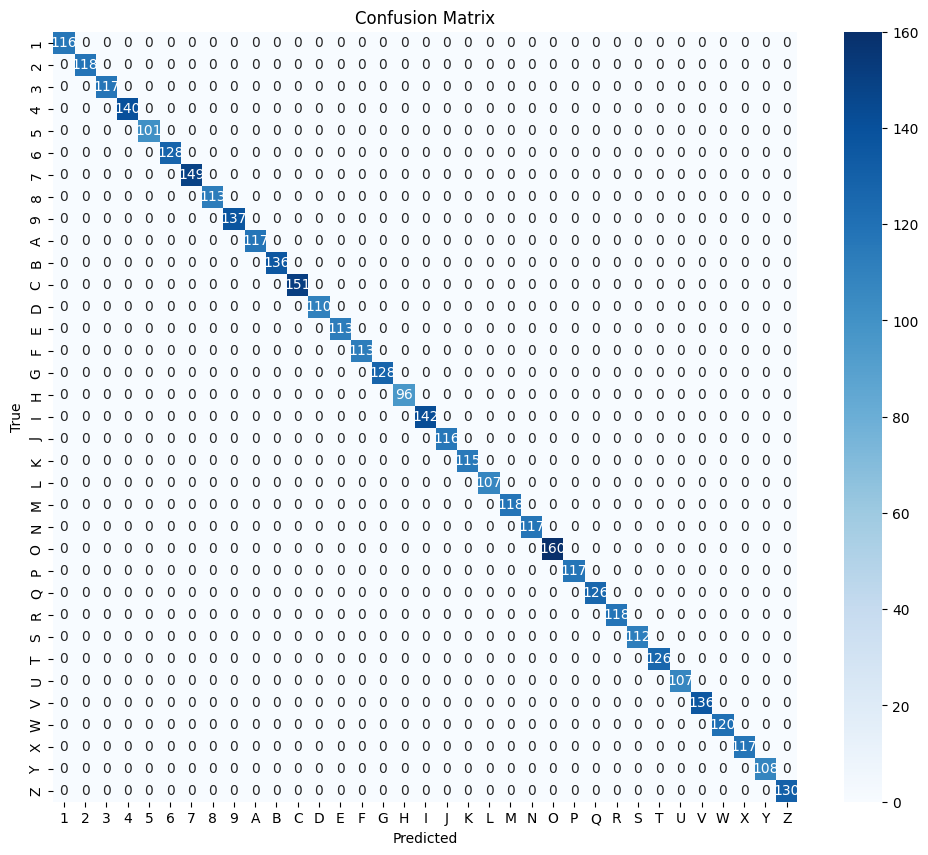

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Run evaluation
evaluate(model, test_loader, device, class_names)